## Where and When Should I Not Be Parking Illegally in NYC?

In [48]:
import os
import pandas as pd
import geopandas as gpd
import subprocess
from geopandas.tools import geocode
import re

%matplotlib inline
%pylab inline
pd.options.display.max_columns = 120
pd.options.display.max_rows = 120

Populating the interactive namespace from numpy and matplotlib


In [6]:
data_folder = '/Users/geoffperrin/Desktop/python_sandbox/NYPD/data'

### Read in NYPD parking data

In [10]:
'''
taken from:
https://data.cityofnewyork.us/Social-Services/nypd-7-major-felony-incidents/k384-xu3q/data
filtered to Agency: NYPD
Complaint Type: Illegal Parking
'''

nypd_df_raw = pd.read_csv(data_folder+'/nypd_7_major_felony_incidents.csv')
nypd_df = nypd_df_raw[['Created Date', 'Closed Date', 'Agency', 'Complaint Type', 'Descriptor', 'Location Type', \
                       'Community Board', 'Borough', 'Latitude', 'Longitude']]

#subset to just blocked sidewalks
nypd_df = nypd_df[nypd_df.Descriptor == "Blocked Sidewalk"]
nypd_df.head()

,Created Date,Closed Date,Agency,Complaint Type,Descriptor,Location Type,Community Board,Borough,Latitude,Longitude
9,09/04/2015 08:52:01 PM,09/04/2015 11:24:31 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,05 QUEENS,QUEENS,40.722005,-73.904019
37,09/04/2015 04:43:36 PM,09/04/2015 10:15:45 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,03 STATEN ISLAND,STATEN ISLAND,40.562832,-74.148151
46,09/04/2015 08:46:01 AM,09/04/2015 12:14:42 PM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,02 STATEN ISLAND,STATEN ISLAND,40.593806,-74.075633
54,09/05/2015 12:03:41 AM,NaN,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,0 Unspecified,Unspecified,NaN,NaN
57,09/04/2015 07:17:15 PM,09/05/2015 02:51:48 AM,NYPD,Illegal Parking,Blocked Sidewalk,Street/Sidewalk,01 BROOKLYN,BROOKLYN,40.713757,-73.936055


In [11]:
nypd_df['create_date_time'] = pd.to_datetime(nypd_df['Created Date'])
nypd_df['closed_date_time'] = pd.to_datetime(nypd_df['Closed Date'])

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [24]:
nypd_df['create_date'] = nypd_df['create_date_time'].dt.date
nypd_df['day_of_week'] = nypd_df.create_date.apply(lambda x: x.weekday())

#control for Friday / Saturday nights
nypd_df['weekend'] = 0
nypd_df['weekend'][(nypd_df['day_of_week'] == 4) | (nypd_df['day_of_week'] == 5)] = 1

#control for hour of day
nypd_df['hour_of_day'] = nypd_df.create_date_time.apply(lambda x: x.hour)

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

### Time Series of Counts 

In [18]:
nypd_count_df = nypd_df.groupby(['create_date'], as_index=False)['Agency'].count()
nypd_count_df.columns = ['create_date', 'sidewalk_parking_count']

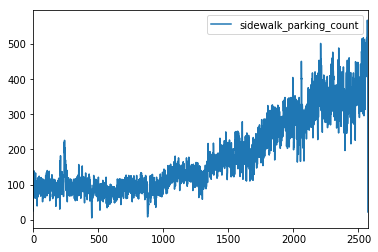

In [19]:
nypd_count_df[['create_date', 'sidewalk_parking_count']].plot()

### Count by Hour of Day

In [25]:
nypd_hour_df = nypd_df.groupby(['hour_of_day'], as_index=False)['Agency'].count()
nypd_hour_df.columns = ['hour_of_day', 'sidewalk_parking_count']

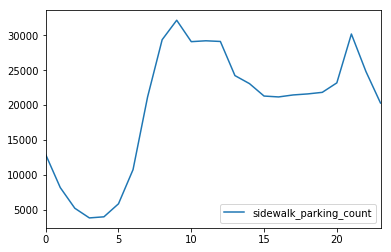

In [27]:
nypd_hour_df[['sidewalk_parking_count']].plot()

### Read in ACS Data

In [51]:
'''
taken from: 
https://public.enigma.com/datasets/household-size-by-vehicles-available/f9d2a838-00ce-4d17-90bb-9a20e22f515a?filter=%2B%5B%3Estusab%5BNY%5D%5D
'''
acs_df_raw = pd.read_csv(data_folder+'/ACS_vehicle_data.csv')
#subset to just NYC
acs_df = acs_df_raw[(acs_df_raw.b08201_001 == "795") & (acs_df_raw.sumlevel == "NY")]
acs_nyc_df = acs_df[acs_df['name'].str.contains("NYC")]
acs_nyc_df = acs_nyc_df.iloc[:,0:17]
acs_nyc_df.columns = ['name', 'name2', 'geoid', 'state', 'summary_level', 'total_pop',\
                     'total_pop_moe', 'no_vehicle_pop', 'no_vehicle_pop_moe',\
                     'one_vehicle_pop', 'one_vehicle_pop_moe', 'two_vehicle_pop',\
                     'two_vehicle_pop_moe', 'three_vehicle_pop', 'three_vehicle_pop_moe',\
                     'four_or_more_vehicle_pop', 'four_or_more_vehicle_pop_moe']
acs_nyc_df = acs_nyc_df[acs_nyc_df.total_pop!="None"]

### Do a little regex stuff to get useable x-walk for community district name

In [53]:
# Harmonize community district name for ACS

dict_boro2 = {'Bronx': 'BX', 'Brooklyn': 'BK', 'Manhattan': 'MN', 'Staten': 'SI', 'Queens': 'QN'}

def add_zero(f):
    if len(f) == 1:
        return '0'+f
    else:
        return f

acs_nyc_df['cd_num'] = [re.search("[0-9]+", i).group(0) for i in acs_nyc_df['name']]
acs_nyc_df['cd_num_2'] = [add_zero(i) for i in acs_nyc_df['cd_num']]

acs_nyc_df['boro'] = [dict_boro2[re.search('[^\s]+', i[4:]).group(0)] for i in acs_nyc_df['name']]

acs_nyc_df['cd_id'] = acs_nyc_df['boro'] + acs_nyc_df['cd_num_2']

,name,name2,geoid,state,summary_level,total_pop,total_pop_moe,no_vehicle_pop,no_vehicle_pop_moe,one_vehicle_pop,one_vehicle_pop_moe,two_vehicle_pop,two_vehicle_pop_moe,three_vehicle_pop,three_vehicle_pop_moe,four_or_more_vehicle_pop,four_or_more_vehicle_pop_moe,cd_num,cd_num_2,boro,cd_id
4426,NYC-Bronx Community District 8--Riverdale,Fieldston & Kingsbridge PUMA; New York,79500US3603701,NY,795,41340,2204,18159,2022,15901,1792,6211,1362,997,465,72,93,8,08,BX,BX08
4427,NYC-Bronx Community District 12--Wakefield,Williamsbridge & Woodlawn PUMA; New York,79500US3603702,NY,795,47321,2068,20550,2024,17023,1866,7736,1106,1695,535,317,226,12,12,BX,BX12
4428,NYC-Bronx Community District 10--Co-op City,Pelham Bay & Schuylerville PUMA; New York,79500US3603703,NY,795,47025,2996,17824,2844,17543,2690,9678,1774,1657,652,323,254,10,10,BX,BX10
4429,NYC-Bronx Community District 11--Pelham Parkway,Morris Park & Laconia PUMA; New York,79500US3603704,NY,795,43622,2358,19885,1896,14914,1757,7278,1121,1209,403,336,167,11,11,BX,BX11
4430,NYC-Bronx Community District 3 & 6--Belmont,Crotona Park East & East Tremont PUMA; New York,79500US3603705,NY,795,57839,2600,34753,2379,12807,1401,9985,1686,232,209,62,102,3,03,BX,BX03


In [89]:
acs_nyc_df = acs_nyc_df[['cd_id', 'total_pop', 'no_vehicle_pop', 'one_vehicle_pop', 'two_vehicle_pop', \
                         'three_vehicle_pop', 'four_or_more_vehicle_pop']]
acs_nyc_df['vehicle_pop'] = acs_nyc_df['one_vehicle_pop'].astype(int) + 2*acs_nyc_df['two_vehicle_pop'].astype(int) + \
                            3*acs_nyc_df['three_vehicle_pop'].astype(int) + 4*acs_nyc_df['four_or_more_vehicle_pop'].astype(int)

acs_nyc_df['total_pop'] = acs_nyc_df['total_pop'].astype(int)
acs_nyc_df = acs_nyc_df[['cd_id', 'total_pop', 'vehicle_pop']]
acs_nyc_df.head()

,cd_id,total_pop,vehicle_pop
4426,BX08,41340,31602
4427,BX12,47321,38848
4428,BX10,47025,43162
4429,BX11,43622,34441
4430,BX03,57839,33721


### Merge ACS data to NYPD data

In [91]:
nypd_cd_df = nypd_df.groupby(['Community Board'], as_index=False)['Agency'].count()
nypd_cd_df.columns = ['community_board', 'sidewalk_parking_count']

In [92]:
nypd_cd_df['cd_num'] = nypd_cd_df['community_board'].str.split(' ', 1).str[0]
nypd_cd_df['cd_boro'] = nypd_cd_df['community_board'].str.split(' ', 1).str[1]

In [94]:
# Harmonize identifier

dict_boro = {'BRONX': 'BX', 'BROOKLYN': 'BK', 'MANHATTAN': 'MN', 'STATEN ISLAND': 'SI', 'QUEENS': 'QN'}

nypd_cd_df['cd_num'] = nypd_cd_df['community_board'].str.split(' ', 1).str[0]
nypd_cd_df['cd_boro'] = nypd_cd_df['community_board'].str.split(' ', 1).str[1]

nypd_cd_df['cd_id'] = nypd_cd_df['cd_boro'].map(dict_boro) + nypd_cd_df['cd_num']
nypd_cd_df = nypd_cd_df[['sidewalk_parking_count', 'cd_id']]
nypd_cd_df.head()

,sidewalk_parking_count,cd_id
0,3813,NaN
1,2490,BX01
2,10682,BK01
3,5236,MN01
4,12983,QN01


In [98]:
nypd_cd_acs_df = nypd_cd_df.merge(acs_nyc_df, on='cd_id')
nypd_cd_acs_df['pct_sidewalk_parking'] = nypd_cd_acs_df.sidewalk_parking_count * 1.0 / nypd_cd_acs_df.vehicle_pop
result = nypd_cd_acs_df.sort(['pct_sidewalk_parking'], ascending=False)
result.head()

/Users/geoffperrin/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,sidewalk_parking_count,cd_id,total_pop,vehicle_pop,pct_sidewalk_parking
40,19909,BK12,45297,30736,0.647742
10,7038,MN03,73463,14250,0.493895
19,11016,BK06,50618,23560,0.467572
5,9222,BK02,58068,22004,0.419106
33,15849,BK10,47520,37949,0.417639


In [100]:
# read in community district shapefile
'''
http://www1.nyc.gov/site/planning/data-maps/open-data/districts-download-metadata.page
'''
cd_raw = gpd.read_file(data_folder + '/nycd.shp')
cd_raw = cd_raw.to_crs(epsg=4326)

In [111]:
# Standardize community district code like before
'''
1 Manhattan (New York County)
2 Bronx (Bronx County)
3 Brooklyn (Kings County)
4 Queens (Queens County)
5 Staten Island (Richmond County)
'''
dict_boro_num = {'2': 'BX', '3': 'BK', '1': 'MN', '5': 'SI', '4': 'QN'}
cd_raw['cd_id'] = cd_raw.BoroCD.astype(str).str[:1].map(dict_boro_num) + cd_raw.BoroCD.astype(str).str[1:]
cd_raw.head(50)

,BoroCD,Shape_Area,Shape_Leng,geometry,cd_id
0,311,1.031759e+08,51566.989006,POLYGON ((-73.97299433938895 40.60881414183559...,BK11
1,412,2.673336e+08,65933.851319,POLYGON ((-73.80168266553355 40.66632235260422...,QN12
2,314,8.217567e+07,49291.791502,POLYGON ((-73.95630035122711 40.65504828186446...,BK14
3,313,8.814953e+07,65746.939737,"POLYGON ((-73.98372152615245 40.5958210782504,...",BK13
4,310,1.113147e+08,44794.111421,"POLYGON ((-74.03231084300103 40.6440392145137,...",BK10
5,312,9.952550e+07,52245.830711,POLYGON ((-73.97139631688151 40.64825778614741...,BK12
6,309,4.533042e+07,29962.791843,"POLYGON ((-73.928722045946 40.6644955697186, -...",BK09
7,104,4.929184e+07,67935.226947,POLYGON ((-73.99393694248319 40.77317951100026...,MN04
8,304,5.666322e+07,37008.101061,POLYGON ((-73.89646625128921 40.68233642250924...,BK04
9,484,1.237923e+08,247830.589693,(POLYGON ((-73.93177580884334 40.5578995624182...,QN84


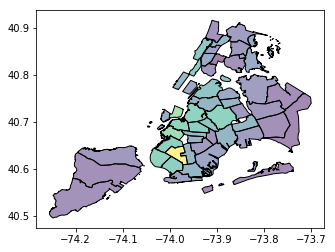

In [109]:
cd_map = cd_raw.merge(nypd_cd_acs_df, on='cd_id')
cd_map.plot(column='pct_sidewalk_parking')

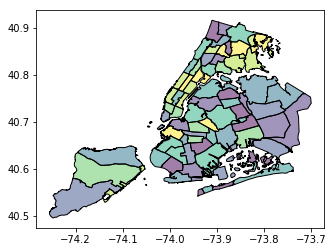

In [110]:
cd_raw.plot()